In [2]:
import random
from collections import Counter
from pathlib import Path
from Bio import SeqIO
import pandas as pd

# -----------------------------
# Config
# -----------------------------
SEED = 42
random.seed(SEED)





GENERATIONS = 1000  # number of random mutations per sequence
FASTA_FOLDER = Path("/Users/ishaharris/Projects/ribolings/data/virus/rna_cds_fasta")
VIRUS_FAMILIES = ["Arena", "Calici","Corona","Filo","Hanta","Picorna", "Peribunya", "Orthomyxo", "Rhabdo","Flavi"]  # specify which virus families to process

BIAS_TRANSITION = 3.0  # transition bias

# -----------------------------
# Genetic code / amino acid groups
# -----------------------------
genetic_code = {
    "TTT":"F","TTC":"F","TTA":"L","TTG":"L","CTT":"L","CTC":"L","CTA":"L","CTG":"L",
    "ATT":"I","ATC":"I","ATA":"I","ATG":"M",
    "GTT":"V","GTC":"V","GTA":"V","GTG":"V",
    "TCT":"S","TCC":"S","TCA":"S","TCG":"S","AGT":"S","AGC":"S",
    "CCT":"P","CCC":"P","CCA":"P","CCG":"P",
    "ACT":"T","ACC":"T","ACA":"T","ACG":"T",
    "GCT":"A","GCC":"A","GCA":"A","GCG":"A",
    "TAT":"Y","TAC":"Y","CAT":"H","CAC":"H","CAA":"Q","CAG":"Q",
    "AAT":"N","AAC":"N","AAA":"K","AAG":"K",
    "GAT":"D","GAC":"D","GAA":"E","GAG":"E",
    "TGT":"C","TGC":"C","TGG":"W",
    "CGT":"R","CGC":"R","CGA":"R","CGG":"R","AGA":"R","AGG":"R",
    "GGT":"G","GGC":"G","GGA":"G","GGG":"G",
    "TAA":"*","TAG":"*","TGA":"*"
}

amino_acid_groups = {
    "A": ["R","H","K"],  # basic
    "B": ["D","E"],      # acidic
    "C": ["S","T","N","Q"],  # polar uncharged
    "D": ["C","G","P"],      # special
    "E": ["A","V","I","L","M","F","Y","W"]  # hydrophobic
}

NUCS = ["A","C","G","T"]
TRANSITIONS = {("A","G"), ("G","A"), ("C","T"), ("T","C")}

# -----------------------------
# Helper functions
# -----------------------------
def get_group(aa):
    for group, aas in amino_acid_groups.items():
        if aa in aas:
            return group
    return None

def translate_codon(codon):
    return genetic_code.get(codon.upper(), None)

def choose_mutant_base(base):
    candidates = [b for b in NUCS if b != base]
    weights = [BIAS_TRANSITION if (base,b) in TRANSITIONS else 1.0 for b in candidates]
    return random.choices(candidates, weights, k=1)[0]

def mutate_once(seq):
    """Perform a single random mutation and classify it"""
    pos = random.randrange(len(seq))
    original_base = seq[pos]
    new_base = choose_mutant_base(original_base)
    mutated_seq = seq[:pos] + new_base + seq[pos+1:]

    # Codon positions
    codon_start = (pos // 3) * 3
    original_codon = seq[codon_start:codon_start+3]
    mutated_codon = mutated_seq[codon_start:codon_start+3]

    # Translate codons
    orig_aa = translate_codon(original_codon)
    mut_aa = translate_codon(mutated_codon)

    if mut_aa == "*":
        return "Stop"
    elif orig_aa == mut_aa:
        return "Synonymous"
    else:
        g1 = get_group(orig_aa)
        g2 = get_group(mut_aa)
        if g1 == g2:
            return "Same_Group"
        else:
            return "Different_Group"

# -----------------------------
# Main analysis
# -----------------------------
results = []

for fasta_file in FASTA_FOLDER.glob("*.fasta"):
    virus_family = fasta_file.stem.split("_")[0]
    if virus_family not in VIRUS_FAMILIES:
        continue

    print(f"[PROCESSING] {virus_family} -> {fasta_file.name}")
    records = SeqIO.to_dict(SeqIO.parse(str(fasta_file), "fasta"))

    for name, record in records.items():
        seq = str(record.seq).upper().replace("U","T")
        if len(seq) % 3 != 0:
            seq = seq[:len(seq) - len(seq)%3]  # trim to codon multiples

        counts = {"Synonymous":0, "Stop":0, "Same_Group":0, "Different_Group":0}
        for _ in range(GENERATIONS):
            category = mutate_once(seq)
            counts[category] += 1

        # nucleotide frequencies
        nuc_counts = Counter(seq)
        total_nts = sum(nuc_counts.values())
        freqs = {f"Freq_{nt}": nuc_counts.get(nt,0)/total_nts for nt in NUCS}

        result = {
            "Virus_Family": virus_family,
            "Sequence_Name": name,
            **counts,
            **freqs
        }
        results.append(result)
        print(f"[DONE] {name} -> {counts} | Freqs: {freqs}")

df = pd.DataFrame(results)
cols = ["Virus_Family","Sequence_Name","Synonymous","Stop","Same_Group","Different_Group"] + [f"Freq_{nt}" for nt in NUCS]
df = df[cols]
print("[COMPLETE] Results saved to mutation_classification_all_genes.csv")
df


[PROCESSING] Flavi -> Flavi.fasta
[DONE] lcl|AB003289.1_cds_BAA22476.1_1 -> {'Synonymous': 308, 'Stop': 36, 'Same_Group': 185, 'Different_Group': 471} | Freqs: {'Freq_A': 0.17962246453277056, 'Freq_C': 0.2699026849572048, 'Freq_G': 0.3194981826708876, 'Freq_T': 0.23085942079962482}
[DONE] lcl|AB003292.1_cds_BAA22479.1_1 -> {'Synonymous': 314, 'Stop': 31, 'Same_Group': 182, 'Different_Group': 473} | Freqs: {'Freq_A': 0.1799742056513073, 'Freq_C': 0.2725993668659866, 'Freq_G': 0.316449759643569, 'Freq_T': 0.2306249267206003}
[DONE] lcl|AB021287.1_cds_BAA36518.1_1 -> {'Synonymous': 299, 'Stop': 27, 'Same_Group': 191, 'Different_Group': 483} | Freqs: {'Freq_A': 0.18161566420447883, 'Freq_C': 0.27013717903622936, 'Freq_G': 0.3166842537225935, 'Freq_T': 0.23156290303669833}
[DONE] lcl|AF009606.1_cds_AAB66324.1_1 -> {'Synonymous': 272, 'Stop': 34, 'Same_Group': 207, 'Different_Group': 487} | Freqs: {'Freq_A': 0.19876051350154936, 'Freq_C': 0.30312084993359895, 'Freq_G': 0.28541389995573263, '

Virus_Family                    Sequence_Name  Synonymous  Stop  \
0           Flavi  lcl|AB003289.1_cds_BAA22476.1_1         308    36   
1           Flavi  lcl|AB003292.1_cds_BAA22479.1_1         314    31   
2           Flavi  lcl|AB021287.1_cds_BAA36518.1_1         299    27   
3           Flavi  lcl|AF009606.1_cds_AAB66324.1_1         272    34   
4           Flavi  lcl|AF037405.1_cds_AAC16444.1_1         273    35   
...           ...                              ...         ...   ...   
2082      Picorna    lcl|X56019.1_cds_CAA39496.1_1         266    28   
2083      Picorna    lcl|X79047.1_cds_CAA55650.1_1         276    29   
2084      Picorna    lcl|X80059.1_cds_CAA56365.1_1         266    46   
2085      Picorna    lcl|X84981.1_cds_CAA59341.1_1         287    36   
2086      Picorna    lcl|X96871.1_cds_CAA65615.1_1         276    33   

      Same_Group  Different_Group    Freq_A    Freq_C    Freq_G    Freq_T  
0            185              471  0.179622  0.269903  0.319498  0.230859  
1            182              473  0.179974  0.272599  0.316450  0.230625  
2            191              483  0.181616  0.270137  0.316684  0.231563  
3            207              487  0.198761  0.303121  0.285414  0.212705  
4            224              468  0.326660  0.194387  0.260951  0.218001  
...          ...              ...       ...       ...       ...       ...  
2082         235              471  0.243056  0.273293  0.214120  0.269531  
2083         241              454  0.292768  0.230477  0.243239  0.233516  
2084         220              468  0.286733  0.236035  0.243777  0.233455  
2085         190              487  0.286083  0.228350  0.248861  0.236706  
2086         221              470  0.245174  0.255470  0.228314  0.271042  

[2087 rows x 10 columns]

In [3]:
# Select only numeric columns for correlation
numeric_cols = ["Synonymous","Stop","Same_Group","Different_Group"] + [f"Freq_{nt}" for nt in NUCS]

# Compute correlation matrix
corr_matrix = df[numeric_cols].corr()

# Display
print(corr_matrix)


                 Synonymous      Stop  Same_Group  Different_Group    Freq_A  \
Synonymous         1.000000 -0.155163   -0.265598        -0.360030 -0.348756   
Stop              -0.155163  1.000000   -0.097014        -0.127456  0.284037   
Same_Group        -0.265598 -0.097014    1.000000        -0.750540 -0.014650   
Different_Group   -0.360030 -0.127456   -0.750540         1.000000  0.153988   
Freq_A            -0.348756  0.284037   -0.014650         0.153988  1.000000   
Freq_C             0.309497 -0.273870   -0.452520         0.316609 -0.554409   
Freq_G             0.109532 -0.083651   -0.318924         0.259942 -0.321721   
Freq_T            -0.042984  0.046144    0.596209        -0.557827 -0.174622   

                   Freq_C    Freq_G    Freq_T  
Synonymous       0.309497  0.109532 -0.042984  
Stop            -0.273870 -0.083651  0.046144  
Same_Group      -0.452520 -0.318924  0.596209  
Different_Group  0.316609  0.259942 -0.557827  
Freq_A          -0.554409 -0.321721 -0.

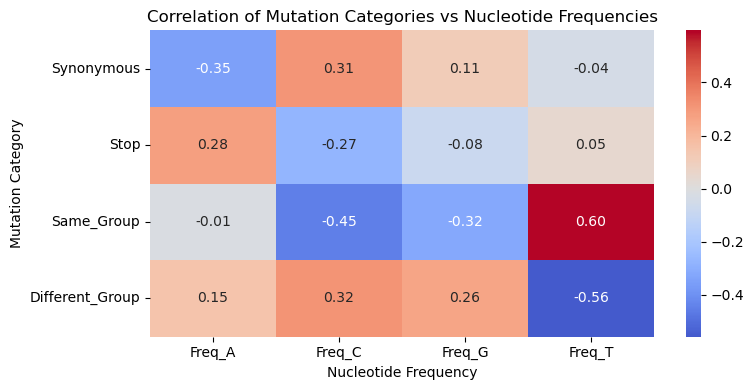

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define columns
nt_cols = [f"Freq_{nt}" for nt in NUCS]
mut_cols = ["Synonymous","Stop","Same_Group","Different_Group"]

# Correlations of NT frequencies vs mutation categories
corr_matrix = df[nt_cols + mut_cols].corr().loc[mut_cols, nt_cols]

# Heatmap
plt.figure(figsize=(8,4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation of Mutation Categories vs Nucleotide Frequencies")
plt.ylabel("Mutation Category")
plt.xlabel("Nucleotide Frequency")
plt.tight_layout()
plt.show()


# Keep recoding until stop codon. record how many gens it takes to reach it

In [12]:
import random
from collections import Counter
from pathlib import Path
import pandas as pd
from scipy.stats import pearsonr

# -----------------------------
# Config
# -----------------------------
SEED = 42
random.seed(SEED)

FOLDER = Path("/Users/ishaharris/Projects/ribolings/data/virus/rna_balanced_fasta")
FAMILIES_TO_RUN = ["Arena","Calici", "Corona","Flavi","Filo","Hanta","Picorna","Paramyxo","Peribunya", "Rhabdo"]
MAX_GENERATIONS = 1000
BIAS_TRANSITION = 3.0

# -----------------------------
# Genetic code / helpers
# -----------------------------
genetic_code = {
    "TTT":"F","TTC":"F","TTA":"L","TTG":"L","CTT":"L","CTC":"L","CTA":"L","CTG":"L",
    "ATT":"I","ATC":"I","ATA":"I","ATG":"M",
    "GTT":"V","GTC":"V","GTA":"V","GTG":"V",
    "TCT":"S","TCC":"S","TCA":"S","TCG":"S","AGT":"S","AGC":"S",
    "CCT":"P","CCC":"P","CCA":"P","CCG":"P",
    "ACT":"T","ACC":"T","ACA":"T","ACG":"T",
    "GCT":"A","GCC":"A","GCA":"A","GCG":"A",
    "TAT":"Y","TAC":"Y","CAT":"H","CAC":"H","CAA":"Q","CAG":"Q",
    "AAT":"N","AAC":"N","AAA":"K","AAG":"K",
    "GAT":"D","GAC":"D","GAA":"E","GAG":"E",
    "TGT":"C","TGC":"C","TGG":"W",
    "CGT":"R","CGC":"R","CGA":"R","CGG":"R","AGA":"R","AGG":"R",
    "GGT":"G","GGC":"G","GGA":"G","GGG":"G",
    "TAA":"*","TAG":"*","TGA":"*"
}

NUCS = ["A","C","G","T"]
TRANSITIONS = {("A","G"), ("G","A"), ("C","T"), ("T","C")}

def parse_fasta(filename: Path):
    records = {}
    header, seq_chunks = None, []
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if header and seq_chunks:
                    records[header] = "".join(seq_chunks).upper().replace("U","T")
                header = line[1:].strip()
                seq_chunks = []
            else:
                seq_chunks.append(line)
        if header and seq_chunks:
            records[header] = "".join(seq_chunks).upper().replace("U","T")
    return records

def nucleotide_freqs(cds):
    c = Counter(cds)
    n = len(cds)
    return {b: c.get(b,0)/n for b in NUCS}

def choose_mutant_base(base, bias_transition=3.0):
    candidates = [b for b in NUCS if b != base]
    weights = [bias_transition if (base,b) in TRANSITIONS else 1.0 for b in candidates]
    return random.choices(candidates, weights, k=1)[0]

def mutate_one(cds, bias_transition=3.0):
    """Mutate a single nucleotide and return (new_cds, codon_index, old_codon, new_codon)."""
    L = len(cds)
    pos = random.randrange(L)
    cur = cds[pos]
    newb = choose_mutant_base(cur, bias_transition)
    new_cds = cds[:pos] + newb + cds[pos+1:]
    
    codon_start = (pos // 3) * 3
    old_codon = cds[codon_start:codon_start+3]
    new_codon = new_cds[codon_start:codon_start+3]
    
    return new_cds, codon_start//3+1, old_codon, new_codon  # codon number 1-indexed

def contains_stop(cds):
    return {i for i in range(0, len(cds), 3) if genetic_code.get(cds[i:i+3], "") == "*"}

# -----------------------------
# Loop through FASTA files
# -----------------------------
results = []

for fasta_file in FOLDER.glob("*.fasta"):
    family_name = fasta_file.stem.split("_")[0]
    if family_name not in FAMILIES_TO_RUN:
        continue

    print(f"[INFO] Processing family {family_name} from file {fasta_file.name}")
    records = parse_fasta(fasta_file)
    print(f"[INFO] {len(records)} genes found")

    for idx, (name, seq) in enumerate(records.items(), 1):
        print(f"  [INFO] Processing gene {idx}/{len(records)}: {name}")
        if len(seq) % 3 != 0:
            seq = seq[:len(seq) - len(seq)%3]
            print(f"    [WARN] Trimmed gene to {len(seq)} nucleotides")

        cds = seq
        freqs = nucleotide_freqs(cds)

        old_stop_positions = contains_stop(cds)
        for gen in range(1, MAX_GENERATIONS+1):
            cds, codon_num, old_codon, new_codon = mutate_one(cds, BIAS_TRANSITION)
            
            new_stop_positions = contains_stop(cds)
            mutation_created_stop = new_stop_positions - old_stop_positions
            
            print(f"    Generation {gen}: codon {codon_num} changed {old_codon} -> {new_codon}", end="")
            if mutation_created_stop:
                print("  <-- STOP CODON CREATED")
                break
            else:
                print("")
            
            old_stop_positions = new_stop_positions  # update for next mutation
        else:
            gen = MAX_GENERATIONS
            print(f"    [INFO] No stop codon induced, capped at {MAX_GENERATIONS}")

        results.append({"family": family_name, "gene": name, **freqs, "generations": gen})

df = pd.DataFrame(results)

# Correlations
print("\n[INFO] Calculating correlations:")
for nuc in NUCS:
    coef, _ = pearsonr(df[nuc], df["generations"])
    print(f"  {nuc} vs generations: {coef:.3f}")

# Average generations per family
avg_gen = df.groupby("family")["generations"].mean()
print("\nAverage generations per virus family:")
print(avg_gen)


[INFO] Processing family Hanta from file Hanta_balanced.fasta
[INFO] 131 genes found
  [INFO] Processing gene 1/131: lcl|AB620100.1_cds_BAK08519.1_1 recoded_to_balance_cyclical
    Generation 1: codon 77 changed AAG -> CAG
    Generation 2: codon 188 changed ATG -> ATA
    Generation 3: codon 96 changed CTT -> TTT
    Generation 4: codon 373 changed ATA -> CTA
    Generation 5: codon 289 changed ACT -> CCT
    Generation 6: codon 64 changed CAA -> CAG
    Generation 7: codon 345 changed AAG -> AAC
    Generation 8: codon 384 changed ATG -> CTG
    Generation 9: codon 373 changed CTA -> TTA
    Generation 10: codon 307 changed TTT -> TCT
    Generation 11: codon 5 changed AAG -> AGG
    Generation 12: codon 109 changed CTA -> CTG
    Generation 13: codon 233 changed GTA -> ATA
    Generation 14: codon 147 changed CAG -> CAT
    Generation 15: codon 230 changed AAA -> AAC
    Generation 16: codon 260 changed ACT -> AAT
    Generation 17: codon 235 changed AGG -> AGC
    Generation 18: co

graphs of results 
- run above first

/var/folders/ls/vwbn46k51_dbtpbp9vjn8kzh0000gq/T/ipykernel_2543/2137664860.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_gen.index, y=avg_gen.values, palette="viridis")


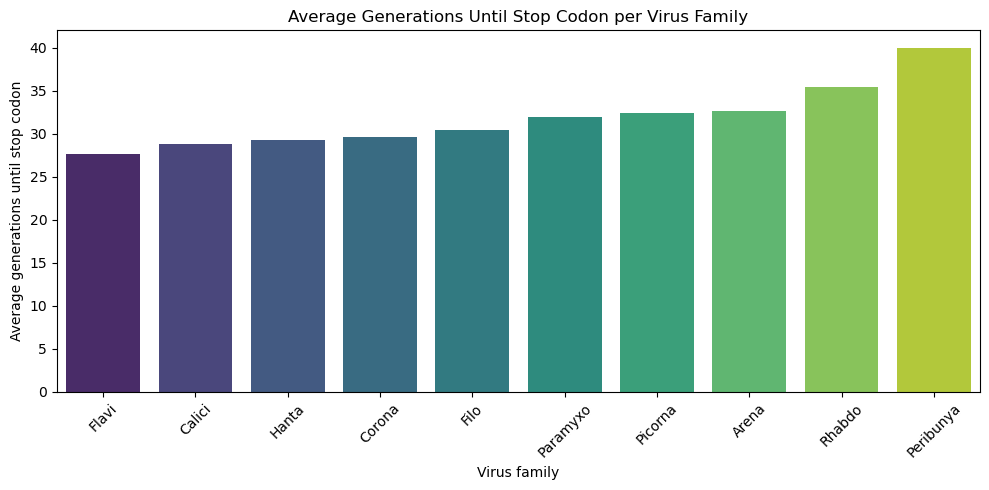

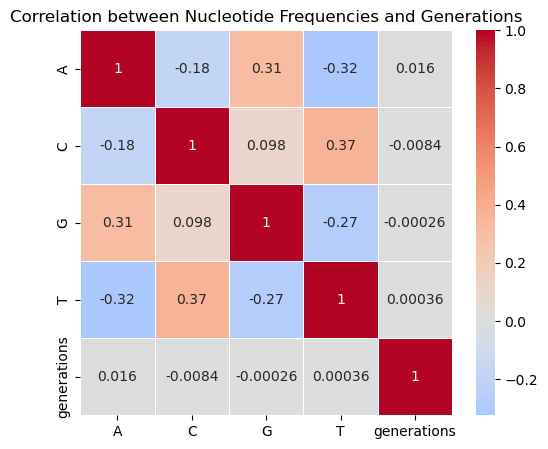

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Bar chart: average generations per family
# -----------------------------
avg_gen = df.groupby("family")["generations"].mean().sort_values()
plt.figure(figsize=(10,5))
sns.barplot(x=avg_gen.index, y=avg_gen.values, palette="viridis")
plt.ylabel("Average generations until stop codon")
plt.xlabel("Virus family")
plt.title("Average Generations Until Stop Codon per Virus Family")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------
# 2. Correlation heatmap: nucleotide freqs vs generations
# -----------------------------
corr_matrix = df[NUCS + ["generations"]].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation between Nucleotide Frequencies and Generations")
plt.show()


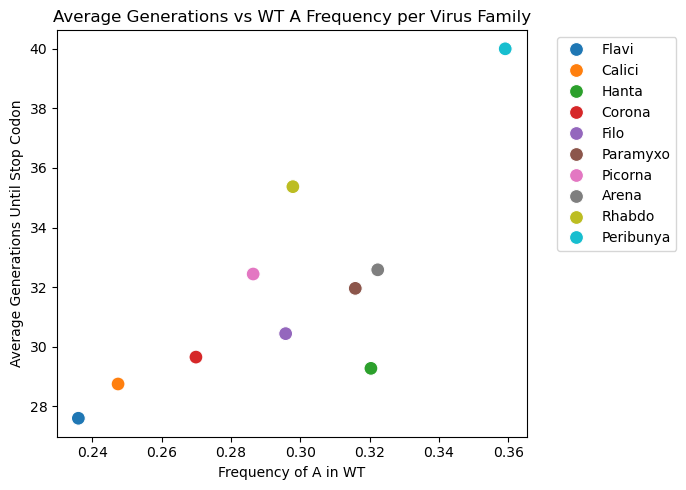

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load WT frequencies
wt_df = pd.read_csv("/Users/ishaharris/Projects/ribolings/data/freqs/wt_freqs.csv")  # columns: VirusFamily, A, C, G, T

# Make sure avg_gen is a DataFrame
avg_gen_df = avg_gen.reset_index().rename(columns={"generations": "AvgGenerations"})

# Merge to get frequencies and avg generations together
plot_df = pd.merge(avg_gen_df, wt_df, left_on="family", right_on="VirusFamily")

# Scatter plot: avg generations vs a chosen nucleotide frequency (example: 'A')
plt.figure(figsize=(7,5))
sns.scatterplot(data=plot_df, x="A", y="AvgGenerations", hue="VirusFamily", s=100)
plt.xlabel("Frequency of A in WT")
plt.ylabel("Average Generations Until Stop Codon")
plt.title("Average Generations vs WT A Frequency per Virus Family")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


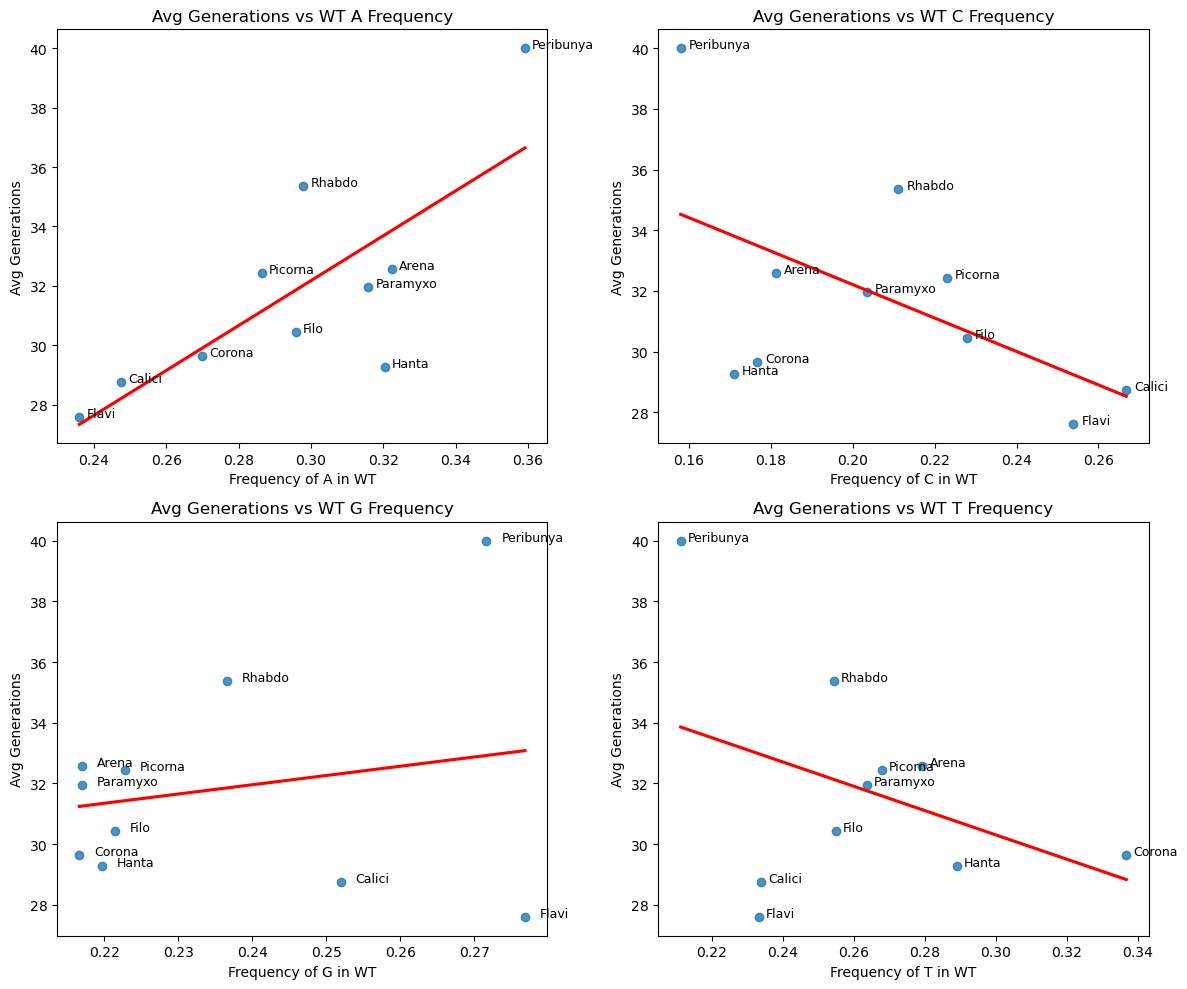

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Load WT frequencies
# -----------------------------
wt_df = pd.read_csv("/Users/ishaharris/Projects/ribolings/data/freqs/wt_freqs.csv")  # columns: VirusFamily, A, C, G, T

# -----------------------------
# Prepare avg generations
# -----------------------------
# avg_gen: Series with family index
avg_gen_df = avg_gen.reset_index().rename(columns={"generations": "AvgGenerations"})

# Merge
plot_df = pd.merge(avg_gen_df, wt_df, left_on="family", right_on="VirusFamily")

# -----------------------------
# Scatter plots with LOBF for each nucleotide
# -----------------------------
nucleotides = ["A", "C", "G", "T"]
fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.flatten()

for ax, nuc in zip(axes, nucleotides):
    sns.regplot(data=plot_df, x=nuc, y="AvgGenerations", scatter=True, ci=None,
                line_kws={"color": "red"}, ax=ax)
    # Add point labels
    for i, row in plot_df.iterrows():
        ax.text(row[nuc] + 0.002, row["AvgGenerations"], row["VirusFamily"], fontsize=9)
    ax.set_xlabel(f"Frequency of {nuc} in WT")
    ax.set_ylabel("Avg Generations")
    ax.set_title(f"Avg Generations vs WT {nuc} Frequency")

plt.tight_layout()
plt.show()


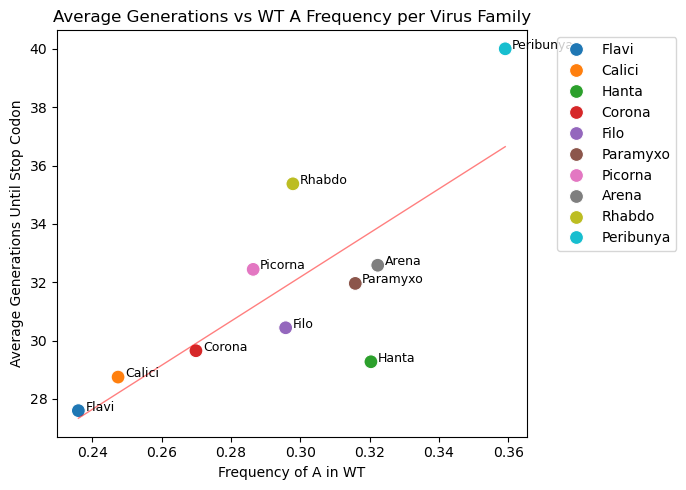

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load WT frequencies
wt_df = pd.read_csv("/Users/ishaharris/Projects/ribolings/data/freqs/wt_freqs.csv")  # columns: VirusFamily, A, C, G, T

# Prepare avg generations
avg_gen_df = avg_gen.reset_index().rename(columns={"generations": "AvgGenerations"})

# Merge
plot_df = pd.merge(avg_gen_df, wt_df, left_on="family", right_on="VirusFamily")

# Scatter plot for Adenine
plt.figure(figsize=(7,5))
sns.scatterplot(data=plot_df, x="A", y="AvgGenerations", hue="VirusFamily", s=100, palette="tab10")
sns.regplot(data=plot_df, x="A", y="AvgGenerations", scatter=False, ci=None,
            line_kws={"color": "red", "alpha": 0.5, "linewidth": 1})

# Add labels
for i, row in plot_df.iterrows():
    plt.text(row["A"] + 0.002, row["AvgGenerations"], row["VirusFamily"], fontsize=9)

plt.xlabel("Frequency of A in WT")
plt.ylabel("Average Generations Until Stop Codon")
plt.title("Average Generations vs WT A Frequency per Virus Family")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


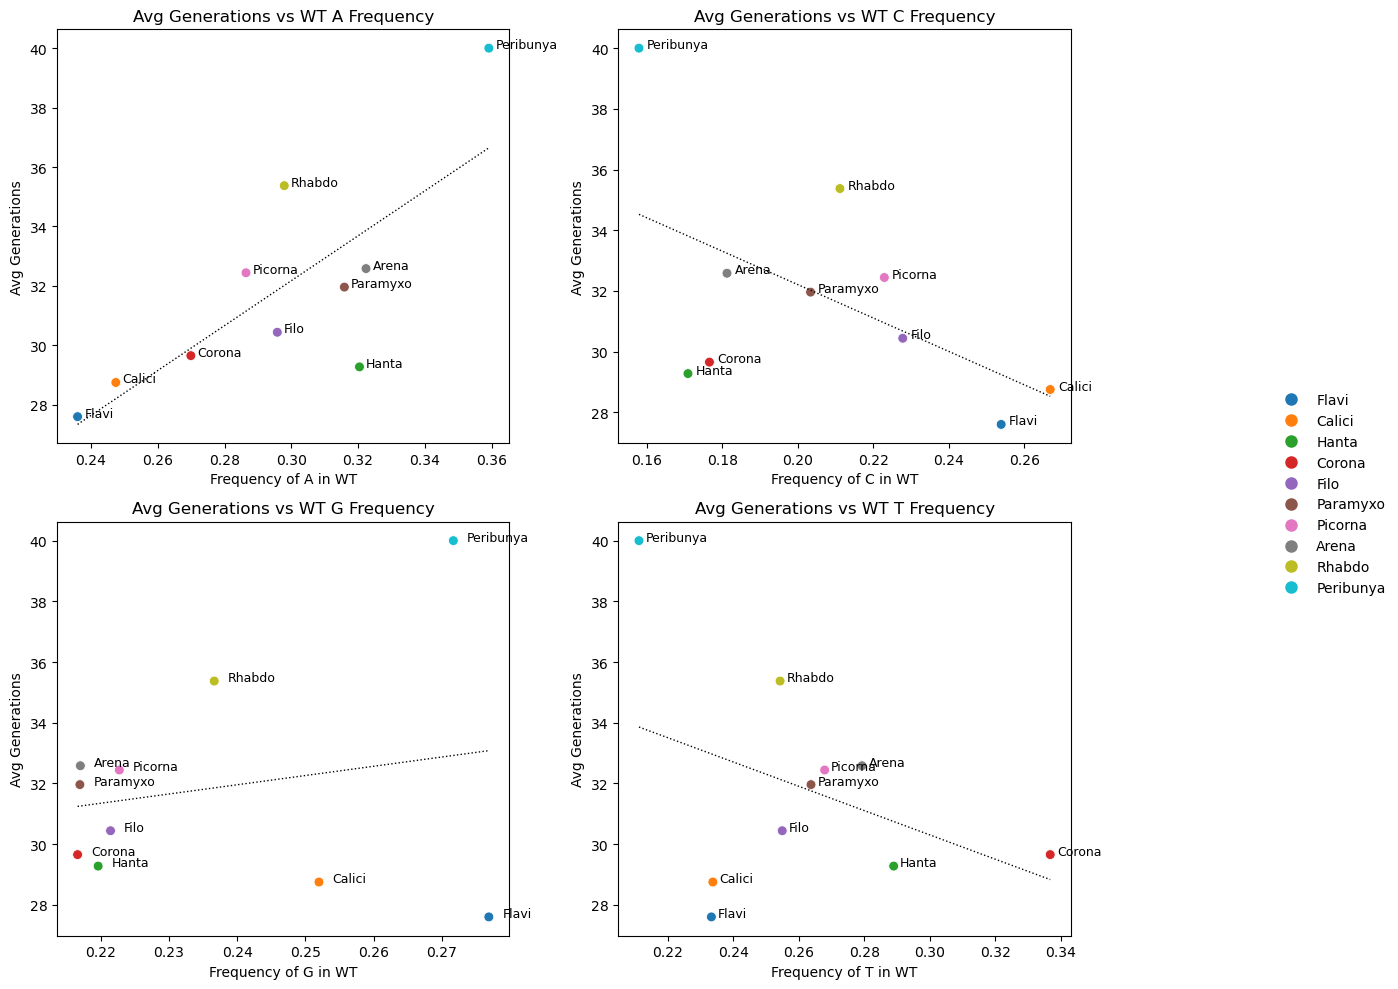

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Load WT frequencies
# -----------------------------
wt_df = pd.read_csv("/Users/ishaharris/Projects/ribolings/data/freqs/wt_freqs.csv")  # columns: VirusFamily, A, C, G, T

# -----------------------------
# Prepare avg generations
# -----------------------------
avg_gen_df = avg_gen.reset_index().rename(columns={"generations": "AvgGenerations"})
plot_df = pd.merge(avg_gen_df, wt_df, left_on="family", right_on="VirusFamily")

# -----------------------------
# Scatter plots with dotted, thin LOBF and coloured points
# -----------------------------
nucleotides = ["A", "C", "G", "T"]
fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()

palette = sns.color_palette("tab10", n_colors=plot_df["VirusFamily"].nunique())
hue_order = plot_df["VirusFamily"].unique()  # ensures consistent legend order

for ax, nuc in zip(axes, nucleotides):
    sns.scatterplot(
        data=plot_df,
        x=nuc,
        y="AvgGenerations",
        hue="VirusFamily",
        palette=palette,
        hue_order=hue_order,
        s=50,
        ax=ax,
        legend=False  # turn off individual legends
    )
    sns.regplot(
        data=plot_df,
        x=nuc,
        y="AvgGenerations",
        scatter=False,
        ci=None,
        line_kws={"color": "black", "linestyle": ":", "linewidth": 1},
        ax=ax
    )
    for i, row in plot_df.iterrows():
        ax.text(row[nuc] + 0.002, row["AvgGenerations"], row["VirusFamily"], fontsize=9)
    ax.set_xlabel(f"Frequency of {nuc} in WT")
    ax.set_ylabel("Avg Generations")
    ax.set_title(f"Avg Generations vs WT {nuc} Frequency")

# -----------------------------
# Single legend to the right
# -----------------------------
# Create a single dummy scatter for the legend
handles = []
for i, family in enumerate(hue_order):
    handles.append(plt.Line2D([], [], marker='o', color=palette[i], linestyle='', markersize=8, label=family))

fig.legend(handles=handles, loc='center right', frameon=False, fontsize=10)
plt.tight_layout(rect=[0, 0, 0.8, 1])  # leave space on right for legend
plt.show()
